# Notebook con resultados

## Imports

In [54]:
from seaborn import load_dataset
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting

In [55]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

## Creación de DataFrames

In [56]:
storage = HDF5FeatureStorage("./test.hdf5")
df_fc = storage.read_df('BOLD_parccortical-TianxS3x3TxMNI6thgeneration')
df_alff = storage.read_df('BOLD_ALFF_parccortical-TianxS3x3TxMNI6thgeneration')
df_participants = pd.read_csv("./participants.tsv", sep="\t")
df_participants.rename(columns={"participant_id": "subject"}, inplace=True)
df_participants.set_index("subject", inplace=True)
parcellation_labels = df_alff.columns.values

In [57]:
df_alff_full = df_alff.merge(df_participants, on="subject")
df_fc_full = df_fc.merge(df_participants, on="subject")

In [ ]:
es_control = lambda x: 0 if x =="CONTROL" else 1
df_fc_full["is_control"] = df_fc_full["diagnosis"].apply(es_control)
df_alff_full["is_control"] = df_alff_full["diagnosis"].apply(es_control)

## Conectividad funcional promedio por cada grupo de sujetos

<Figure size 1000x800 with 0 Axes>

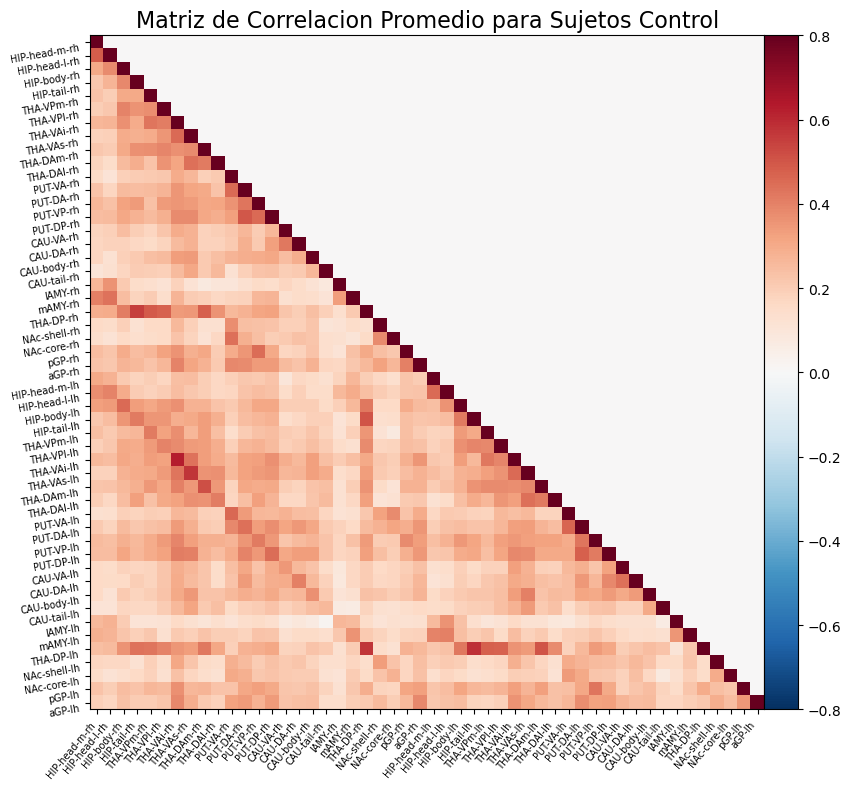

<Figure size 1000x800 with 0 Axes>

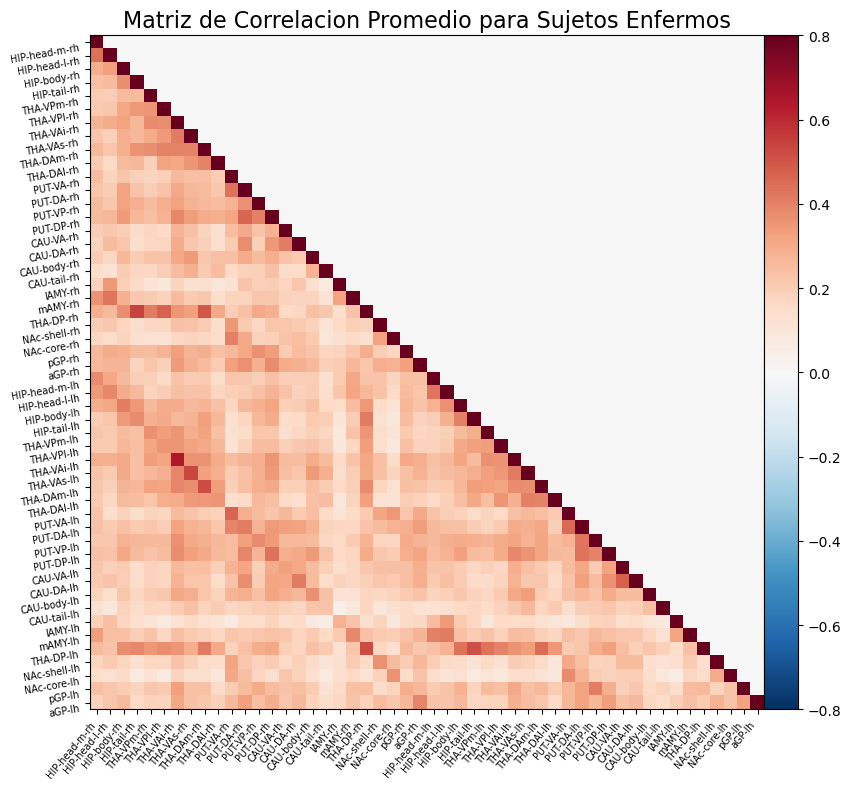

In [121]:
def plot_correlation_matrix(lower_tri_array, parcellation, title="Matriz de Correlacion"):
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    corr_matrix = np.zeros((n, n))
    
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array

    plt.figure(figsize=(10, 8))
    plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=parcellation, colorbar=True, vmax=0.8, vmin=-0.8, title=title)
    plt.show()

# Get the mean value of the correlation matrix for all subjects with diagnosis AD
lower_mean_control = df_fc_full[df_fc_full['is_control'] == 0][df_fc.columns].mean().values
lower_mean_disease = df_fc_full[df_fc_full['is_control'] == 1][df_fc.columns].mean().values


plot_correlation_matrix(lower_mean_control, parcellation=parcellation_labels, title="Matriz de Correlacion Promedio para Sujetos Control")
plot_correlation_matrix(lower_mean_disease, parcellation=parcellation_labels, title="Matriz de Correlacion Promedio para Sujetos Enfermos")


## Exploración con distintos modelos

In [60]:
df_fc_dev, df_fc_test = train_test_split(df_fc_full, test_size=0.2, stratify=df_fc_full["is_control"])
df_alff_dev, df_alff_test = df_alff_full.loc[df_fc_dev.index], df_alff_full.loc[df_fc_test.index]

x_fc_cols, x_alff_cols, target = list(df_fc.columns), list(df_alff.columns),  "is_control" 

### Hacemos PCA para reducir la dimensionalidad de los datos (de ~1200 a 50 columnas)

In [61]:
cv = StratifiedKFold(n_splits = 5)
X_fc_dev = df_fc_dev
pca = PCA(n_components=50)
X_fc_dev_pca = pca.fit_transform(X_fc_dev[x_fc_cols])

In [62]:
df_fc_dev_pca = pd.DataFrame(X_fc_dev_pca, columns = list([str(x) for x in range(X_fc_dev_pca.shape[1])]), index=df_fc_dev.index)
df_fc_dev_pca_cols = list(df_fc_dev_pca.columns)
df_fc_dev_pca[target] = df_fc_dev[target].values

### SVM:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide para Functional Connectivity

In [63]:
def creator(model_name, hyperparams):
    creator_ = PipelineCreator(problem_type="classification")
    creator_.add("zscore")
    creator_ .add(model_name, **hyperparams)
    return creator_

In [64]:
def nested_cv(col_names, target_name, data, model):
    scores, model_final, inspector = run_cross_validation(
        X=col_names,
        y=target_name,
        data = data,
        model=model,
        cv=cv,
        return_inspector=True,
        return_train_score=True,
        return_estimator="all",
        search_params={"cv":StratifiedKFold(n_splits=5)},
        scoring = "roc_auc"
    )
    return scores, model_final, inspector

In [65]:
explor_hyperparams_df_fc = pd.DataFrame()

In [66]:
creator_svm_lin = creator("svm", {"kernel":"linear", "C":np.logspace(-3,3,20)})
scores_fc_svm_lin, model_svm_fc_lin, inspector_fc_svm_lin = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_lin)
explor_hyperparams_df_fc["svm_lin"] = scores_fc_svm_lin["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
  warn_with_log(


In [67]:
creator_svm_rbf = creator("svm", {"probability":True, "kernel":"rbf", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_rbf, model_svm_fc_rbf, inspector_fc_svm_rbf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_rbf)
explor_hyperparams_df_fc["svm_rbf"] = scores_fc_svm_rbf["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
  warn_with_log(


In [68]:
creator_svm_sigmoid = creator("svm", {"probability":True, "kernel":"sigmoid", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_sigmoid, model_svm_fc_sigmoid, inspector_fc_svm_sigmoid = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_sigmoid)
explor_hyperparams_df_fc["svm_sigmoid"] = scores_fc_svm_sigmoid["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
  warn_with_log(


### Random Forests

In [69]:
creator_rf= creator("rf", {"n_estimators":[10,30,70,100,200], "max_depth":[None,5,25,50]})
scores_fc_rf, model_fc_rf, inspector_fc_rf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_rf)
explor_hyperparams_df_fc["rf"] = scores_fc_rf["test_score"]

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
  warn_with_log(


In [72]:
explor_hyperparams_df_fc

,svm_lin,svm_rbf,svm_sigmoid,rf
0,0.409091,0.354978,0.398268,0.482684
1,0.704348,0.576087,0.717391,0.713043
2,0.580435,0.189130,0.646739,0.516304
3,0.532609,0.550000,0.497826,0.592391
4,0.529545,0.506818,0.450000,0.435227


Text(0.5, 1.0, 'Resultados para Nested-CV en FC')

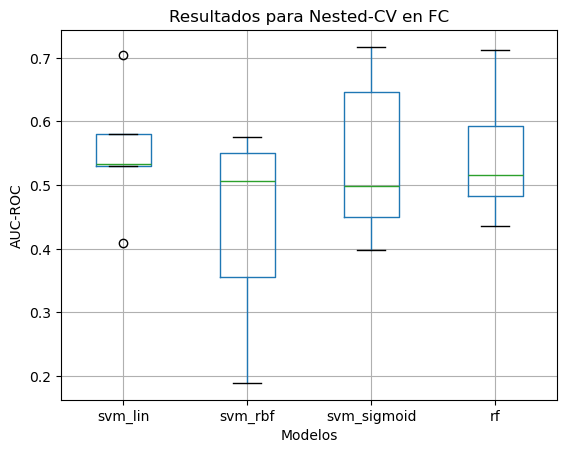

In [120]:
explor_hyperparams_df_fc.boxplot()
plt.xlabel("Modelos")
plt.ylabel("AUC-ROC")
plt.title("Resultados para Nested-CV en FC")

### MODELO FINAL FC

In [74]:
final_model_fc = model_fc_rf.best_estimator_
X_fc_test, y_fc_test = df_fc_test.drop(columns=["is_control"])[df_fc.columns], df_fc_test["is_control"]
X_fc_test_pca = pca.fit_transform(X_fc_test)

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
preds_fc = final_model_fc.predict_proba(X_fc_test_pca)[:,1]
auc_rf = roc_auc_score(y_fc_test, preds_fc)

In [77]:
auc_rf

0.5741758241758241

## Prediccion usando ALFF

In [78]:
explor_hyperparams_df_alff = pd.DataFrame()

### Random Forst ALFF

In [79]:
scores_alff_rf, model_alff_rf, inspector_alff_rf = nested_cv(x_alff_cols, target, df_alff_dev, creator_rf)
explor_hyperparams_df_alff["rf"] = scores_alff_rf["test_score"]

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

### SVM (kernels lineal, rbf y sigmoide) ALFF:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide para los datos de ALFF

In [80]:
scores_alff_svm_lin, model_svm_alff_lin, inspector_alff_svm_lin = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_lin)
explor_hyperparams_df_alff["svm_lin"] = scores_alff_svm_lin["test_score"]

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

In [95]:
scores_alff_svm_rbf, model_svm_alff_rbf, inspector_alff_svm_rbf = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_rbf)
explor_hyperparams_df_alff["svm_rbf"] = scores_alff_svm_rbf["test_score"]

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

In [96]:
scores_alff_svm_sigmoid, model_svm_alff_sigmoid, inspector_alff_svm_sigmoid = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_sigmoid)
explor_hyperparams_df_alff["svm_sigmoid"] = scores_alff_svm_sigmoid["test_score"]

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

### MODELO FINAL ALFF

Text(0.5, 1.0, 'Resultados para Nested-CV en ALFF')

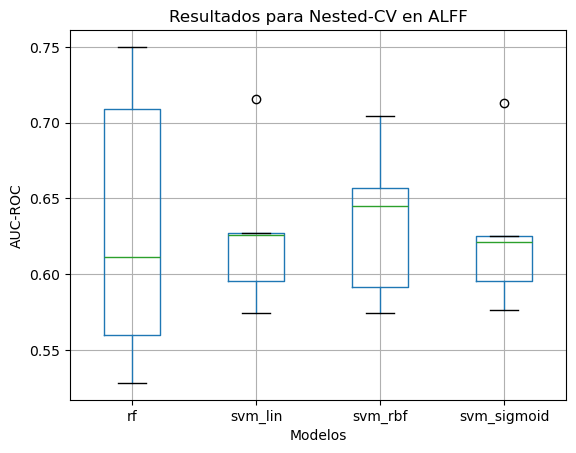

In [119]:
explor_hyperparams_df_alff.boxplot()
plt.xlabel("Modelos")
plt.ylabel("AUC-ROC")
plt.title("Resultados para Nested-CV en ALFF")

In [107]:
modelo_final_alff = model_svm_alff_rbf.best_estimator_

In [108]:
X_test_alff, y_test_alff = df_alff_test.drop(columns=["is_control"])[df_alff.columns], df_alff_test["is_control"]

In [111]:
preds_alff = modelo_final_alff.predict_proba(X_test_alff)[:,1]
auc_rf = roc_auc_score(y_test_alff, preds_alff)
auc_rf

0.5322802197802199